In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#list the columns in Measurement
list(session.query(Measurement).first().__dict__.keys())[1:]

['station', 'prcp', 'id', 'date', 'tobs']

In [10]:
#list the columns in Station 
list(session.query(Station).first().__dict__.keys())[1:]

['latitude', 'elevation', 'station', 'longitude', 'id', 'name']

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

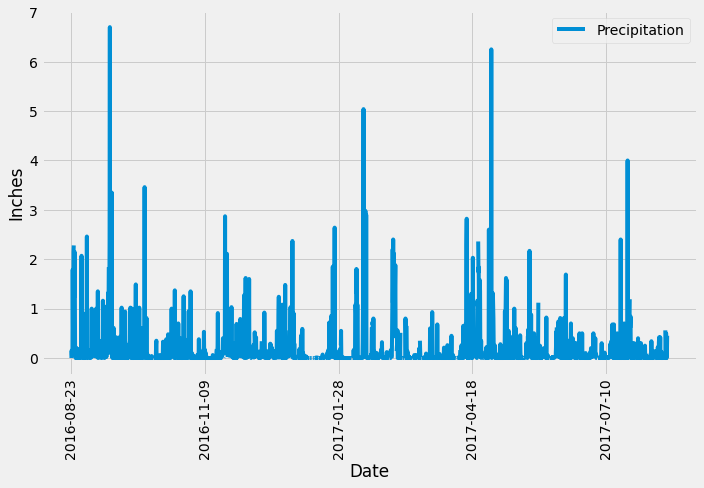

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(last_date[0], '%Y-%m-%d')\
             .date() - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
past_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
past_year_df=pd.DataFrame(past_year, columns=['Date','Precipitation'])
past_year_df.set_index('Date', inplace=True)

# Sort the dataframe by date
past_year_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
past_year_df.plot(kind='line', rot=90, figsize=(10,7), legend=True)

plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('Images/Precipitation_Last_Year.png')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_year_df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
pd.DataFrame(session.query(Measurement.station.distinct(), func.count('*')).group_by(Measurement.station).order_by(func.count('*').desc()),
        columns=['Station ID', 'Count'])

,Station ID,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station=='USC00519281')

# put the query results into a dataframe
active_station_df = pd.DataFrame(active_station, columns=['Station','tobs'])

# calculate the statistical information about the temperature
active_station_df['tobs'].describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: tobs, dtype: float64

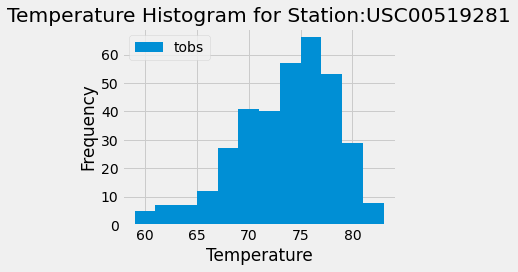

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_12months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station=='USC00519281').\
                filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

active_station_12months_df = pd.DataFrame(active_station_12months, columns=['date','tobs'])
active_station_12months_df.plot(kind='hist', legend=True, bins=12)
plt.xlabel('Temperature')
plt.title('Temperature Histogram for Station:USC00519281')
plt.tight_layout()
plt.savefig('Images/Temp_hist_most_active_station.png')
plt.show()

# Bonus: Temperature Analysis I

In [18]:
# Identify the average temperature for June
tobs_06 = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()

print(f"Average Temperature in June: {np.mean(tobs_06)}") 

Average Temperature in June: 74.94411764705882


In [19]:
# Identify the average temperature for December
tobs_12 = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()

print(f"Average Temperature in December: {np.mean(tobs_12)}") 

Average Temperature in December: 71.04152933421226


From the above, there is approximately 4F difference in average temperation between June and December.

Given that the all the stations might not be measuring exactly everyday, these 2 groups have different sizes and hence unpaied t-test is most appropriate.

In [20]:
# convert temperatures to flattened lists
tobs_06_list = np.ravel(tobs_06).tolist()
tobs_12_list = np.ravel(tobs_12).tolist()

ttest = list(scipy.stats.ttest_ind(tobs_06_list,tobs_12_list))
print(f't-statistic = {ttest[0]}, p-value={ttest[1]}')

t-statistic = 31.60372399000329, p-value=3.9025129038616655e-191


Given that the p-value is less than 0.5, the difference in means is statistically significant.

## Bonus Challenge Assignment: Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set


# Close session

In [23]:
# Close Session
session.close()